In [1]:
import torch.optim as optim
import torch
import argparse
import numpy as np
import random
import os
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import argparse
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.loader import DataLoader
import pandas as pd
from probing import *
from utils.general import *
from rdkit import Chem
from rdkit.Chem import Draw

def get_args_parser():
    # Training settings
    # ======= Usually default settings
    parser = argparse.ArgumentParser(description='GNN baselines on ogbgmol* data with Pytorch Geometrics')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--device', type=int, default=0,
                        help='which gpu to use if any (default: 0)')
    parser.add_argument('--drop_ratio', type=float, default=0.5,
                        help='dropout ratio (default: 0.5)')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='input batch size for training (default: 64)')
    parser.add_argument('--num_workers', type=int, default=2,
                        help='number of workers (default: 0)')
    parser.add_argument('--dataset_name', type=str, default="ogbg-molhiv",
                        help='dataset name (default: ogbg-molhiv/moltox21/molpcba)')
    parser.add_argument('--feature', type=str, default="full",
                        help='full feature or simple feature')
    parser.add_argument('--bottle_type', type=str, default='std',
                        help='bottleneck type, can be std or sem')
    # ==== Model Structure ======
        # ----- Backbone
    parser.add_argument('--backbone_type', type=str, default='gcn',
                        help='backbone type, can be gcn, gin, gcn_virtual, gin_virtual')
    parser.add_argument('--emb_dim', type=int, default=300,
                        help='dimensionality of hidden units in GNNs (default: 300)')  
    parser.add_argument('--num_layer', type=int, default=5,
                        help='number of GNN message passing layers (default: 5)')
        # ---- SEM
    parser.add_argument('--L', type=int, default=30,
                        help='No. word in SEM')
    parser.add_argument('--V', type=int, default=10,
                        help='word size in SEM')
                        
        # ---- Head-type
    parser.add_argument('--head_type', type=str, default='linear',
                        help='Head type in interaction, linear or mlp')    
    return parser


args = get_args_parser()
args = args.parse_args(args=[])
#args = args.parse_args()
args.device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

## Prepare for the probing data

In [2]:
if args.dataset_name == 'ogbg-molhiv':
    smiles_path = 'E:\\P4_Graph\\dataset\\ogbg_molhiv\\mapping\\mol.csv.gz'
    args.batch_size = 4113
elif args.dataset_name == 'ogbg-molpcba':
    smiles_path = 'E:\\P4_Graph\\dataset\\ogbg_molpcba\\mapping\\mol.csv.gz'

selected_prop = ['NumSaturatedRings', 'NumAromaticRings', 'NumAromaticCarbocycles', 'fr_aniline', 'fr_ketone_Topliss', 
                 'fr_ketone', 'fr_bicyclic', 'fr_methoxy', 'fr_para_hydroxylation', 'fr_pyridine', 'fr_benzene']

dataset = PygGraphPropPredDataset(name = args.dataset_name)
args.num_tasks = dataset.num_tasks
split_idx = dataset.get_idx_split()
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, drop_last=False,
                        num_workers=args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, drop_last=False,
                        num_workers=args.num_workers)

valid_smiles = pd.read_csv(smiles_path).iloc[split_idx['valid']].smiles.values
valid_smiles = valid_smiles.tolist()
test_smiles = pd.read_csv(smiles_path).iloc[split_idx['test']].smiles.values
test_smiles = test_smiles.tolist()

valid_desc_names, valid_properties = compute_properties(valid_smiles)
test_desc_names, test_properties = compute_properties(test_smiles)

## Prepare the model

In [37]:
# ====== Generate features
def get_features(args, model,loader):
    with torch.no_grad():
        for step, batch in enumerate(loader):
            batch = batch.to(args.device)
            msg, hid = model.task_forward(batch)
        msg = msg.reshape(msg.shape[0],-1)
        return msg.cpu()
    
def model_probing(args, model, run_random=False):
# ====== Generate representations
    embd_valid = get_features(args,model,valid_loader)
    embd_test = get_features(args,model,test_loader)
    performs, rnd_performs = [], []

    for prop in tqdm(selected_prop):
        x_train = embd_valid
        y_train = valid_properties[prop].values.copy()
        #y_train[y_train>1] = 1 # binarize
        x_test = embd_test
        y_test = test_properties[prop].values.copy()
        #y_test[y_test>1] = 1 # binarize

        performs.append(linear_probing_regression(embedding_train=x_train, y_train=y_train, embeding_test=x_test, 
                                           y_test=y_test, seed=args.seed, scale=True))
        if run_random:
            np.random.shuffle(y_train)
            np.random.shuffle(y_test)
            rnd_performs.append(linear_probing_regression(embedding_train=x_train, y_train=y_train, embeding_test=x_test, 
                                               y_test=y_test, seed=args.seed, scale=True))
        else:
            rnd_performs = performs
    probing_performance = np.array(performs)
    random_performance = np.array(rnd_performs)
    #perf = pd.DataFrame(np.column_stack((probing_performance, random_performance)),
    #                index=selected_prop,
    #                columns=['MAE', 'AUC', 'rnd_MAE', 'rnd_AUC'])
    return probing_performance, random_performance

def get_probing_result(args, ckp_path, run_random=False):
    model = get_init_net(args)
    model.load_state_dict(torch.load(ckp_path),strict=True)
    perf_seed, rnd = model_probing(args, model, run_random=run_random)
    if run_random:
        return perf_seed, rnd
    else:
        return perf_seed, perf_seed

In [8]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_std\\ogbg-molhiv'
ckp_seed = os.path.join(RESULT_PATH, 'model_seed.pt')
ckp_baseline = os.path.join(RESULT_PATH, 'model_gen_00.pt')

# ====== Init a model, load parameters
args.bottle_type = 'std'
perf_seed, rnd = get_probing_result(args, ckp_seed, run_random=True)
perf_base, _ = get_probing_result(args, ckp_baseline, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.58it/s]


In [9]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\hiv_gcn_semnil_save'
args.bottle_type = 'sem'
ckp_sem_seed = os.path.join(RESULT_PATH, 'model_seed.pt')
perf_sem_seed, rnd_sem = get_probing_result(args, ckp_sem_seed, run_random=True)

ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
perf_sem_gen0, _ = get_probing_result(args, ckp_gen0, run_random=False)

ckp_gen1 = os.path.join(RESULT_PATH, 'model_gen_01.pt')
perf_sem_gen1, _ = get_probing_result(args, ckp_gen0, run_random=False)

ckp_gen2 = os.path.join(RESULT_PATH, 'model_gen_02.pt')
perf_sem_gen2, _ = get_probing_result(args, ckp_gen2, run_random=False)

ckp_gen9 = os.path.join(RESULT_PATH, 'model_gen_09.pt')
perf_sem_gen9, _ = get_probing_result(args, ckp_gen9, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.72it/s]


In [10]:
perf_std = pd.DataFrame(np.column_stack((perf_base, perf_seed ,rnd)),
                      index=selected_prop, columns=['baseline', 'initial', 'random'])

In [11]:
perf_std

,baseline,initial,random
NumSaturatedRings,0.875649,0.853661,0.480894
NumAromaticRings,0.946117,0.950674,0.473907
NumAromaticCarbocycles,0.915395,0.818599,0.487375
fr_aniline,0.702283,0.623222,0.495664
fr_ketone_Topliss,0.667251,0.550044,0.486955
fr_ketone,0.690353,0.559500,0.485911
fr_bicyclic,0.691690,0.614902,0.495011
fr_methoxy,0.809298,0.632117,0.508890
fr_para_hydroxylation,0.750503,0.698204,0.505166
fr_pyridine,0.707504,0.664825,0.526890


In [12]:
perf_sem = pd.DataFrame(np.column_stack((perf_sem_gen9, perf_sem_gen2, perf_sem_gen1, perf_sem_gen0, perf_sem_seed, rnd_sem)),
                      index=selected_prop, columns=['Gen9', 'Gen2', 'Gen1','SEM-only','SEM-seed','random'])

In [13]:
perf_sem

,Gen9,Gen2,Gen1,SEM-only,SEM-seed,random
NumSaturatedRings,0.905997,0.915457,0.897723,0.891322,0.869360,0.501488
NumAromaticRings,0.982526,0.990091,0.984313,0.985781,0.953196,0.492913
NumAromaticCarbocycles,0.963368,0.968746,0.936833,0.930591,0.820394,0.504829
fr_aniline,0.781965,0.756725,0.742205,0.724970,0.612566,0.494023
fr_ketone_Topliss,0.777427,0.777259,0.716525,0.714542,0.563629,0.485317
fr_ketone,0.805864,0.789570,0.736670,0.736382,0.582427,0.504622
fr_bicyclic,0.790625,0.800172,0.767374,0.774155,0.630591,0.497448
fr_methoxy,0.917937,0.870451,0.815004,0.821035,0.630314,0.503326
fr_para_hydroxylation,0.816834,0.782206,0.769302,0.752662,0.693421,0.505651
fr_pyridine,0.859988,0.802536,0.761076,0.748324,0.676470,0.491797


In [38]:
RESULT_PATH = 'E:\\P4_Graph\\results\\gcn_sem\\pcba_gcn_semnil_save'
args.bottle_type = 'sem'
args.L = 40
args.V = 20
args.head_type = 'linear'
args.num_tasks = 128

ckp_sem_seed = os.path.join(RESULT_PATH, 'model_seed.pt')
pcba_perf_sem_seed, rnd_sem = get_probing_result(args, ckp_sem_seed, run_random=True)

ckp_gen0 = os.path.join(RESULT_PATH, 'model_gen_00.pt')
pcba_perf_sem_gen0, _ = get_probing_result(args, ckp_gen0, run_random=False)

ckp_gen1 = os.path.join(RESULT_PATH, 'model_gen_01.pt')
pcba_perf_sem_gen1, _ = get_probing_result(args, ckp_gen0, run_random=False)

ckp_gen2 = os.path.join(RESULT_PATH, 'model_gen_02.pt')
pcba_perf_sem_gen2, _ = get_probing_result(args, ckp_gen2, run_random=False)

ckp_gen6 = os.path.join(RESULT_PATH, 'model_gen_06.pt')
pcba_perf_sem_gen6, _ = get_probing_result(args, ckp_gen6, run_random=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


In [39]:
pcba_perf_sem = pd.DataFrame(np.column_stack((pcba_perf_sem_gen6, pcba_perf_sem_gen2, pcba_perf_sem_gen1, pcba_perf_sem_gen0, pcba_perf_sem_seed, rnd_sem)),
                      index=selected_prop, columns=['Gen6', 'Gen2', 'Gen1','SEM-only','SEM-seed','random'])

In [40]:
pcba_perf_sem

,Gen6,Gen2,Gen1,SEM-only,SEM-seed,random
NumSaturatedRings,0.629521,0.627477,0.620273,0.625771,1.148195,1.385969
NumAromaticRings,0.769280,0.767681,0.760085,0.757523,1.333739,1.798735
NumAromaticCarbocycles,0.675061,0.667570,0.680466,0.691199,1.329725,1.565644
fr_aniline,0.438308,0.423200,0.429239,0.429468,0.799209,0.771547
fr_ketone_Topliss,0.351272,0.346861,0.361728,0.365950,0.592389,0.582050
fr_ketone,0.380327,0.397111,0.400458,0.411070,0.747672,0.711749
fr_bicyclic,1.285240,1.294742,1.287720,1.274639,2.200407,2.254804
fr_methoxy,0.362596,0.372167,0.379787,0.371759,0.761655,0.722899
fr_para_hydroxylation,0.437447,0.423514,0.428351,0.445255,0.707462,0.731749
fr_pyridine,0.272217,0.266408,0.275849,0.279940,0.483123,0.483167


In [22]:
tmp = valid_smiles[0]
tmp_g = Chem.MolFromSmiles(tmp)

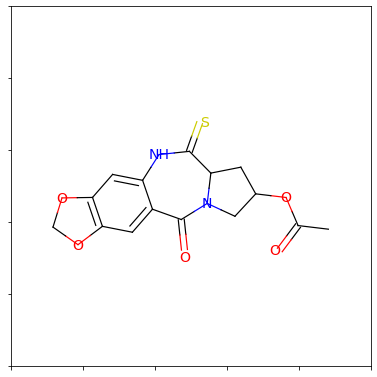

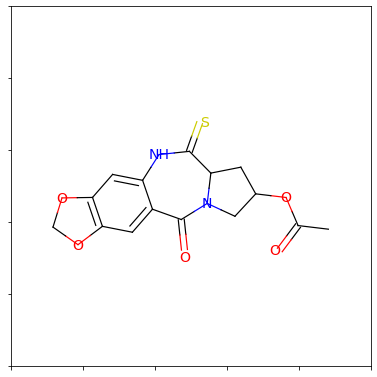

In [23]:
Draw.MolToMPL(tmp_g,size=(200,200))